## Comparing sigma_beta in real data

Initial look at the trans-eQTLs, and get some basic plots:
 - Manhattan plot
 - Q-Q plot
 
Define the input directories and variables here:

In [54]:
resdir = "/usr/users/sbanerj/trans_eqtl_results/gtex_v8_sbopt"
tissuelist = ["esom"]
tejaas_preproc = "raw_std"
sbetalist = [0.142, 0.1]
#sbetalist = [0.004, 0.035, 0.087]
tejaas_method_variants = [f"permnull_sb{x}_knn" for x in sbetalist]
rrfile = "rr.txt"
#chrmlist = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
chrmlist = [19, 20, 21, 22]

In [55]:
import numpy as np
import os
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

In [56]:
def read_tejaas(filename):
    rsidlist = list()
    bplist   = list()
    pvallist = list()
    with open(filename, 'r') as instream:
        next(instream)
        for line in instream:
            linesplit = line.strip().split()
            rsid = linesplit[0]
            bppos = int(linesplit[1])
            pval = float(linesplit[5])
            rsidlist.append(rsid)
            bplist.append(bppos)
            pvallist.append(pval)
    return rsidlist, pvallist, bplist

def read_tejaas_all_chrom(filefmt, chrmlist):
    gwrsids = list()
    gwpvals = list()
    gwnsnps = dict()
    gwbppos = dict()
    
    for chrm in chrmlist:
        filepath = filefmt.format(chrm)
        rsids, pvals, bplist = read_tejaas(filepath)
        gwrsids += rsids
        gwpvals += pvals
        gwnsnps[chrm] = len(rsids)
        gwbppos[chrm] = np.array(bplist)
        
    gwpvals = np.array(gwpvals)
    
    ## Sanity check of p-value
    # Are there any nan p-values?
    nan_mask = np.isnan(gwpvals)
    if np.any(nan_mask):
        print(f'SNPs with nan p-value: {np.sum(nan_mask)}')
        gwpvals[np.where(nan_mask)[0]] = 1.0 ## just ignore this SNP
        
    # Are there any zero p-values
    zero_mask = gwpvals == 0
    if np.any(zero_mask):
        print(f'SNPs with zero p-value: {np.sum(zero_mask)}')
        gwpvals[np.where(zero_mask)[0]] = 1.0#np.min(gwpvals[~zero_mask])    
    
    return gwrsids, gwnsnps, gwbppos, gwpvals

In [57]:
def plot_manhattan(ax, chrmlist, nsnps, bppos, log10pvals, log10cutoff):
    
    i = 0
    start = 0
    lastbp = 0
    xtickposlist = list()
    
    for chrm in chrmlist:
        end = start + nsnps[chrm]
        chrm_bppos = bppos[chrm]
        xtickposlist.append(lastbp + int((chrm_bppos[0] + chrm_bppos[-1]) / 2))

        y = log10pvals[start:end]
        nchoose = np.where(y >= log10cutoff)
        x = lastbp + chrm_bppos[nchoose]
        ax.scatter(x, y[nchoose], alpha = 1.0, s = 6)
        nchoose = np.where(y < log10cutoff)
        nchoose_sparse = np.sort(np.random.choice(nchoose[0], int(nchoose[0].shape[0] / 20), replace=False))
        x = lastbp + chrm_bppos[nchoose_sparse]
        ax.scatter(x, y[nchoose_sparse], color='gainsboro', s = 6, alpha = 0.8)
        
        start = end
        lastbp += chrm_bppos[-1]
        
    ax.set_xlim(0, lastbp)
    ax.plot([0, lastbp], [log10cutoff, log10cutoff], ls = 'dashed', color='gainsboro')
    ax.set_xticks(xtickposlist)
    ax.set_xticklabels(["{:d}".format(x) for x in chrmlist])
    
    return

#### Load results for TEJAAS

In [58]:
gwrsids = dict()
gwnsnps = dict()
gwbppos = dict()
gwpvals = dict()
gwlog10pvals = dict()
for i, sbeta in enumerate(sbetalist):
    filefmt = f'{resdir}/{tissuelist[0]}/tejaas/{tejaas_preproc}/{tejaas_method_variants[i]}/chr' + "{:d}" \
                                                                                                + f'/{rrfile}'
    gwrsids[sbeta], gwnsnps[sbeta], gwbppos[sbeta], gwpvals[sbeta] = read_tejaas_all_chrom(filefmt, chrmlist)
    gwlog10pvals[sbeta] = -np.log10(gwpvals[sbeta])

#### Check the p-value distribution

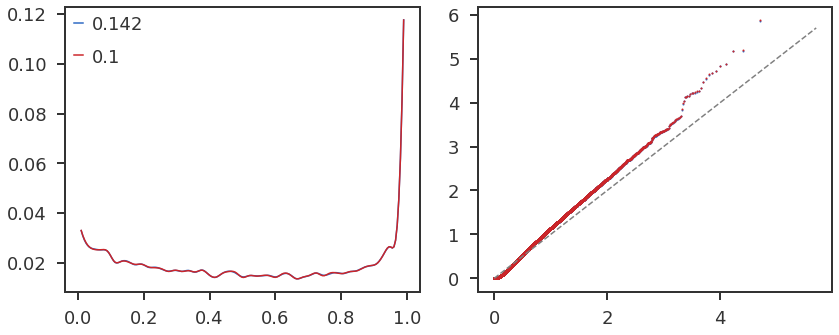

In [59]:
def simpleQQplot(pvals):
    N = pvals.shape[0]
    y = -np.log10(np.sort(pvals))
    x = -np.log10(np.arange(1, N + 1) / N)
    xmax = x[0] + 1
    return x, y, xmax
    
def plotOutline(data, xmin, xmax, nbin = 50, ninterp = 200):
    bins = np.linspace(xmin, xmax, nbin)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], ninterp)

    yhist, _ = np.histogram(data, bins = bins)
    yfreq = yhist / len(data)
    fy = interp1d(xbin, yfreq, kind = 'cubic')
    y = fy(x)
    return x, y

fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
nplotsnp = min(50000, gwpvals[sbetalist[0]].shape[0])
nchoose = np.sort(np.random.choice(gwpvals[sbetalist[0]].shape[0], size = nplotsnp, replace = False))

xmaxlist = list()
for sbeta in sbetalist:
    x, y = plotOutline(gwpvals[sbeta][nchoose], 0, 1)
    ax1.plot(x, y, label = f'{sbeta}')
    x, y, x0 = simpleQQplot(gwpvals[sbeta][nchoose])
    ax2.scatter(x, y, s = 1, label = f'{sbeta}')
    xmaxlist.append(x0)

xmax = max(xmaxlist)
ax2.plot([0, xmax], [0, xmax], ls = 'dashed', color = 'gray')
ax1.legend()
plt.tight_layout()
plt.show()

#### Manhattan Plot

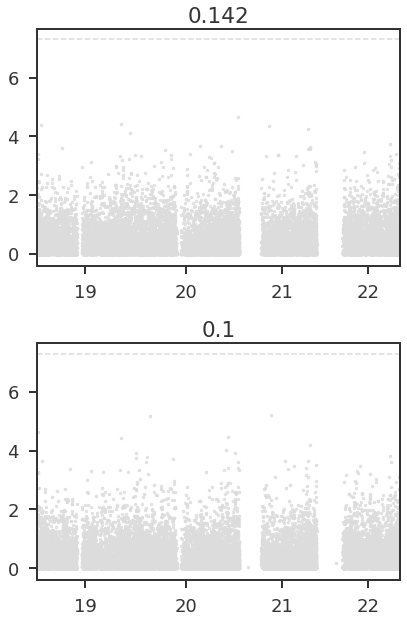

In [60]:
nplot = len(sbetalist)
ncol  = 1
nrow  = len(sbetalist)
figw  = 6
figh  = nrow * 4 + (nrow - 1) * 1
fig = plt.figure(figsize = (figw, figh))

log10cutoff = -np.log10(5e-8)
for i, sbeta in enumerate(sbetalist):
    ax = fig.add_subplot(nrow, ncol, i + 1)
    plot_manhattan(ax, chrmlist, gwnsnps[sbeta], gwbppos[sbeta], gwlog10pvals[sbeta], log10cutoff)
    ax.set_title(f'{sbeta}')

plt.tight_layout()
outfile = f'../plots/manhattan_{tissuelist[0]}_19-22.png'
#plt.savefig(outfile, bbox_inches='tight')
plt.show()

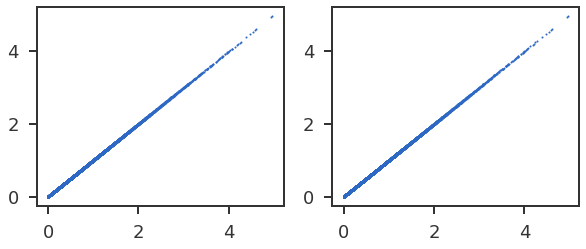

In [61]:
nplot = len(sbetalist)
nplot = len(sbetalist)
ncol  = 4
nrow  = int(nplot / ncol + 0.5)
figw  = ncol * 3.8 + (ncol - 1) * 0.5
figh  = nrow * 3.8 + (nrow - 1) * 0.5
fig = plt.figure(figsize = (figw, figh))

nplotsnp = min(50000, gwpvals[sbetalist[0]].shape[0])
nchoose = np.sort(np.random.choice(gwpvals[sbetalist[0]].shape[0], size = nplotsnp, replace = False))

for i, sbeta in enumerate(sbetalist):
    ax = fig.add_subplot(nrow, ncol, i + 1)
    ax.scatter(gwlog10pvals[sbetalist[-1]][nchoose], gwlog10pvals[sbeta][nchoose], s = 1)

plt.tight_layout()
plt.show()